<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Quantum State Tomography*_ 

The latest version of this notebook is available on https://github.com/IBM/qiskit-sdk-py/tree/master/scripts.

For more information about how to use the IBM Q experience (QX), consult the [IBM Q experience tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Christopher J. Wood, Jay M. Gambetta

## Introduction

In this notebook we demonstrate how to design and run experiments to perform quantum state tomography using QISKit, and demonstrate this using both simulators, and the IBM Quantum Experience. 

Methods implemented. 
* Linear Inversion
* Fast maximum likelihood see [J Smolin, JM Gambetta, G Smith, Phys. Rev. Lett. 108, 070502](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.108.070502) or arxiv: [1106.5458](https://arxiv.org/abs/1106.5458).

In [1]:
# Checking the version of PYTHON; we only support 3 at the moment
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")
    
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import linalg as la
from itertools import permutations
from functools import partial
import networkx as nx

import sys
sys.path.append("../../")
# importing the QISKit
from qiskit import QuantumCircuit, QuantumProgram
import Qconfig

# import basic plot tools
from qiskit.basicplotter import plot_histogram

In [2]:
# import state tomography functions
from tools.tomography import plot_qsphere, plot_state

## Visualizing a quantum state

As an example we will prepare and measure a 2-qubit entangled Bell-state $\frac{1}{\sqrt2}\left(|00\rangle+|11\rangle\right)$ and then using the simulator we will show the different visualization tools we have provided.

In [3]:
Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"]) # set the APIToken and API url

True

In [4]:
# Creating registers
q2 = Q_program.create_quantum_registers("q2", 2)
c2 = Q_program.create_classical_registers("c2", 2)

# quantum circuit to make an entangled bell state 
bell = Q_program.create_circuit("bell", ["q2"], ["c2"])
bell.h(q2[0])
bell.cx(q2[0], q2[1])

>> quantum_registers created: q2 2
>> classical_registers created: c2 2


In [8]:
device = 'local_qasm_simulator' # the device to run on
Q_program.execute(["bell"], device, 1)
state = Q_program.get_data("bell")["quantum_state"]
rho=np.outer(state, state.conj())

In [9]:
state

array([ 0.70710678+0.j,  0.00000000+0.j,  0.00000000+0.j,  0.70710678+0.j])

00  0
[0.0, 0.0, 1.0]
01  0
[1.0, 0.0, 0.0]
10  2.0
[1.0, -2.4492935982947064e-16, 0.0]
11  0
[0.0, 0.0, -1.0]


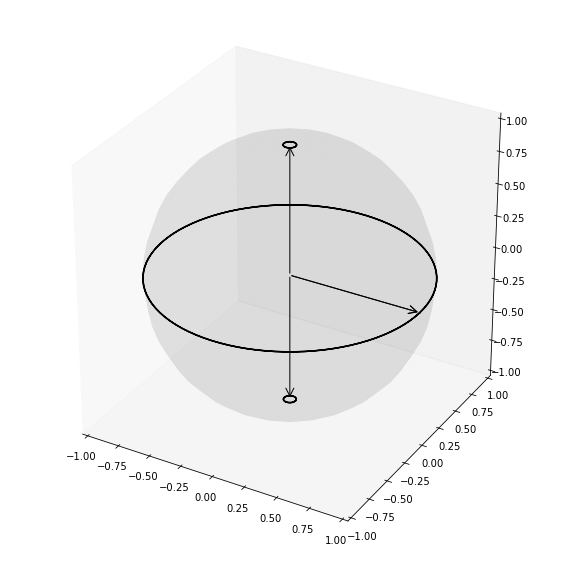

In [7]:
plot_qsphere(state,2)

In [ ]:
plot_state(rho,2,"city")

In [ ]:
plot_state(rho,2,"paulivec")

### Setting up initial state preparation

Next we define a *state preparation circuit* to prepare our system in a desired quantum state. For our example we will apply a Hadamard gate to prepare the first qubit in a $|+\rangle$ state, followed by a CNOT gate to entangle the two qubits:

In [ ]:
# Create a circuit named 'prep'
prep = QP.create_circuit("prep", ["qr"], ["cr"])
# Add H gate of first qubit to 'prep' circuit
prep.h(qr[0])
# Add CNOT gate between qubits to 'prep' circuit
prep.cx(qr[0], qr[1])

### Building tomography measurement circuits

Next we must construct a family of circuits which implement a tomographically complete set of measurements of the qubit. The `statetomo.py` example library contains functions to generate these measurement circuits for general n-qubit systems. We do this by measuring in the X, Y, and Z for each qubit. This results in $3^n$ measurement circuits which must be executed to gather count statistics for the tomographic reconstruction.

The function to build the circuits is:
```
build_tomo_circuits(QP, 'prep', 'qr', 'cr', qubits)
```
The function to construct an array of the the corresponding labels for these circuits is:
```
build_tomo_keys('prep', qubits)
```
where 
- `QP` is the quantum program.
- `'prep'` is the name of the preparation circuit    
- `'qr'` is the name of the quantum registers to be measured
- `'cr'` is the name of the classical registers to store outcomes
- `qubits` is a list of the qubits to be measured. Eg `[i,j]` for `qr[i]`, and `qr[j]`.

In [ ]:
# Qubits being measured
meas_qubits = [0,1]
# Construct the state tomography measurement circuits in QP
build_tomo_circuits(QP, "prep", "qr", "cr", meas_qubits)
# construct list of tomo circuit labels 
circuits = build_tomo_keys("prep", meas_qubits)
print(circuits)

### Testing experiments on a simulator

Now that we have prepared the required circuits for state preparation and measurement, we should test them on a simulator before trying to run them on the real device.

We specify the device, and a number of experiment shots to perform to gather measurement statistics. The larger the number of shots, the more accurate our measurmeent probabilities will be compared to the *true* value.

In [ ]:
# Use the local simulator
device = 'local_qasm_simulator'

# Take 1000 shots for each measurement basis
shots = 1000

# Run the simulation
result = QP.execute(circuits, device, shots)
print(result)

Before doing the tomographic reconstruction we can view the count statistics from the simulation:

In [ ]:
for c in circuits:
    print('Circuit:', c)
    print('Counts:', QP.get_counts(c))

### Reconstructing state from count data

To reconstruct the maximum likelihod estimate of the measured quantum state we use the following function:
```
state_tomography(QP, circuits, shots, total_qubits, meas_qubits)
```
where
- `QP` is the quantum program containing the measurement results
- `circuits` is the array of tomographic measurement circuits measured
- `shots` is the total number of shots for each measurement circuit
- `total_qubits` is the total number of qubits in the system (the length of shot outcome bitstrings)
- `meas_qubits` is an array of the measurement qubit indices

In [ ]:
total_qubits = 2
rho_fit = state_tomography(QP, circuits, shots, total_qubits, meas_qubits)
print('rho =', rho_fit)


We can compare the reconstructed state to the target state vector. We use the Fidelity function, which for a comparing a density matrix $\rho$ to a pure state $|\psi\rangle$ is given by $F = \sqrt{\langle \psi| \rho |\psi\rangle}$. This may be done by the function `fidelity(rho, psi)`. Finally we may wish to visualize the reconstructed state. This can be done by using various plotting libraries. One conveient one is the following which uses the [QuTiP (Quantum Toolbox in Python)](http://qutip.org/) library.

In [ ]:
# target state is (|00>+|11>)/sqrt(2)
target = np.array([1., 0., 0., 1.]/np.sqrt(2.))

# calculate fidelity
F_fit = fidelity(rho_fit, target)

# visualize the state
plot_state(rho_fit, F_fit)

Note that since our simulator is *perfect* the output state should be *exactly* the Bell-state, so we should obtain F = 1. Why is it not in our case? Since we can never directly *see* the final state we must obtain information about it via measurements. We would only obtain the *true* probabilities for the state in the limit of infinite measurement shots. Hence we have statistical error in our reconstruction due to having imperfect information about the state itself. Try running with different number of shots on the simulator and see how it effects the fidelity of the reconstruction.

### Running on a real device

Now that we've checked our simple tomography experiment worked, lets try it out on the IBM Quantum Experience! To do this we must have attached our API key, and it is good practice to set a limit on the number of credits to use:

In [ ]:
# Use the IBM Quantum Experience
device = 'ibmqx2'

# Take 1000 shots for each measurement basis
# Note: reduce this number for larger number of qubits
shots = 1000

# set max credits
max_credits = 5

# set API token and url
QP.set_api(Qconfig.APItoken, Qconfig.config["url"])

# Run the simulation
result = QP.execute(circuits, device, shots, max_credits, wait=20, timeout=240)
print(result)

As before we can check our results, and check our tomographically reconstructed state.

In [ ]:
# print measurement results
for c in circuits:
    print('Circuit:', c)
    print('Counts:', QP.get_counts(c))

Notice that for measurement results the bitstrings are now actually those for 5 qubits, even though we only measured one. This is because the QX is a 5-qubit quantum processor. To reconstruct the single qubit state from these results we use `total_qubits=5`. Note also that the qubit ordering in this bitstrings is `q[4]q[3]q[2]q[1]q[0]`

In [ ]:
rho_fit_real = state_tomography(QP, circuits, shots, 5, meas_qubits)
F_fit_real = fidelity(rho_fit_real, target)
plot_state(rho_fit_real, F_fit_real)

The fidelity of our reconstructed state if 94%, not bad!

### Further examples

To see further examples of performing tomography on up to 5-qubit entangled state see the [cat-state-tomography](cat-state-tomography.ipynb) workbook.